In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import signal
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.metrics import *

from utils import plot_confusion_matrix

In [2]:
AUDIO_BASEPATH = 'data/measurment-2/raw/'
AUDIO_FILE = '230428-003.wav'

audio_path = os.path.join(AUDIO_BASEPATH, AUDIO_FILE)

In [3]:
CALIBRATION_BASEPATH = 'data/measurment-2/calibrations/'
CALIBRATION_FILE = '230428-004-calibration-30dB.wav'

calibration_path = os.path.join(CALIBRATION_BASEPATH, CALIBRATION_FILE)

In [4]:
audio, sr = librosa.load(audio_path, sr=None, mono=False)
audio = audio[0,:]

length = audio.shape[0] / sr

print('Audio length: {:.2f} seconds'.format(length))
print('Sample rate: {} Hz'.format(sr))

Audio length: 1568.49 seconds
Sample rate: 48000 Hz


In [5]:
REF_EFF = 20e-5 # Pa
CAL_SPL = 123.8 # dB

def calculate_calibration_gain(calibration_path, ref_eff=REF_EFF, cal_spl=CAL_SPL, printing=True):
    calibration, sr = librosa.load(calibration_path, sr=None, mono=True)
    length = calibration.shape[0] / sr
    
    calibration_rms = np.sqrt(np.mean(calibration**2))
    calibration_rms_db = 20 * np.log10(calibration_rms / 1)
    calibration_spl = 20 * np.log10(calibration_rms / ref_eff)

    gain_db = calibration_spl - cal_spl
    calibration_gain = 10**(gain_db / 20)

    if printing:
        print(f'Calibration file: {calibration_path}')
        print(f'Calibration length: {length:.2f} seconds')
        print(f'Calibration RMS: {calibration_rms_db:.2f} dB (ref 1 Pa)')
        print(f'Calibration SPL: {calibration_spl:.2f} dB (ref 20 uPa)')
        print(f'Calibration gain: {gain_db:.2f} dB ({calibration_gain})')
        print()
    
    return calibration_gain

calibration_gain = calculate_calibration_gain(calibration_path)

Calibration file: data/measurment-2/calibrations/230428-004-calibration-30dB.wav
Calibration length: 5.88 seconds
Calibration RMS: -9.76 dB (ref 1 Pa)
Calibration SPL: 64.22 dB (ref 20 uPa)
Calibration gain: -59.58 dB (0.0010497809295782082)



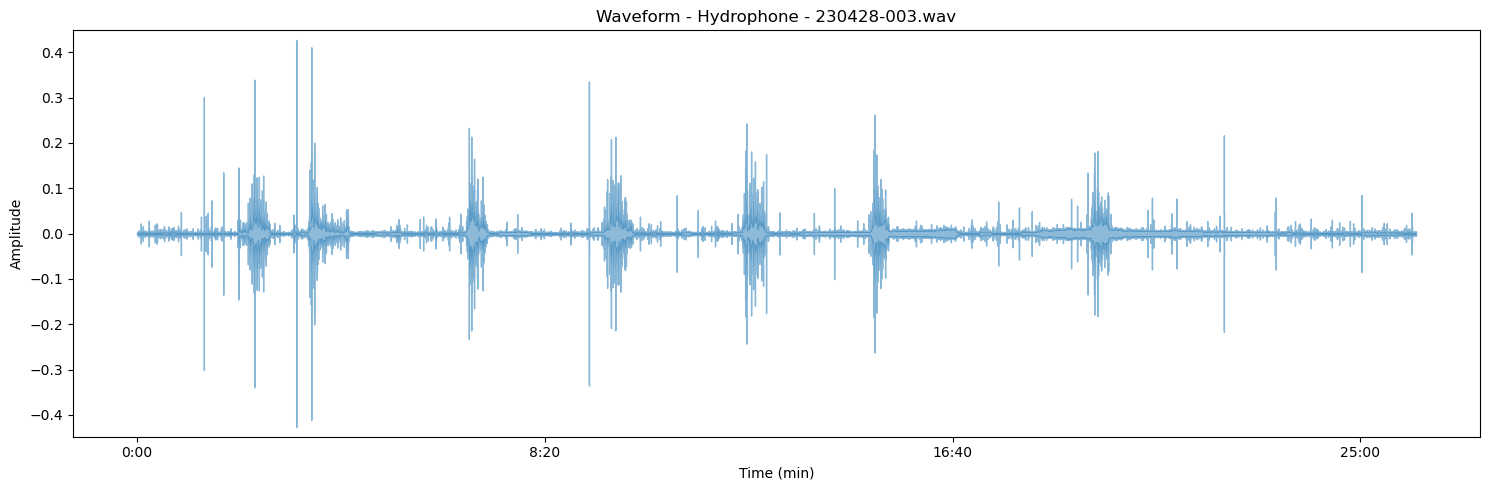

In [6]:
y_max = np.max(np.abs(audio)) * 1.05

plt.figure(figsize=(15, 5))

librosa.display.waveshow(audio, sr=sr, alpha=0.5)
plt.ylim(-y_max, y_max)
plt.title(f'Waveform - Hydrophone - {AUDIO_FILE}')
plt.ylabel('Amplitude')
time_unit = 'min' if audio.shape[0] / sr > 60 else 's'
plt.xlabel(f'Time ({time_unit})')

plt.tight_layout()

plt.show()

In [7]:
NFFT = 1024
HOP_LENGTH = 512
TOP_DB = 80

spectrogram = librosa.stft(audio, n_fft=NFFT, hop_length=HOP_LENGTH)
spectrogram_dB = librosa.amplitude_to_db(np.abs(spectrogram), top_db=TOP_DB, ref=1) - 20 * np.log10(calibration_gain)

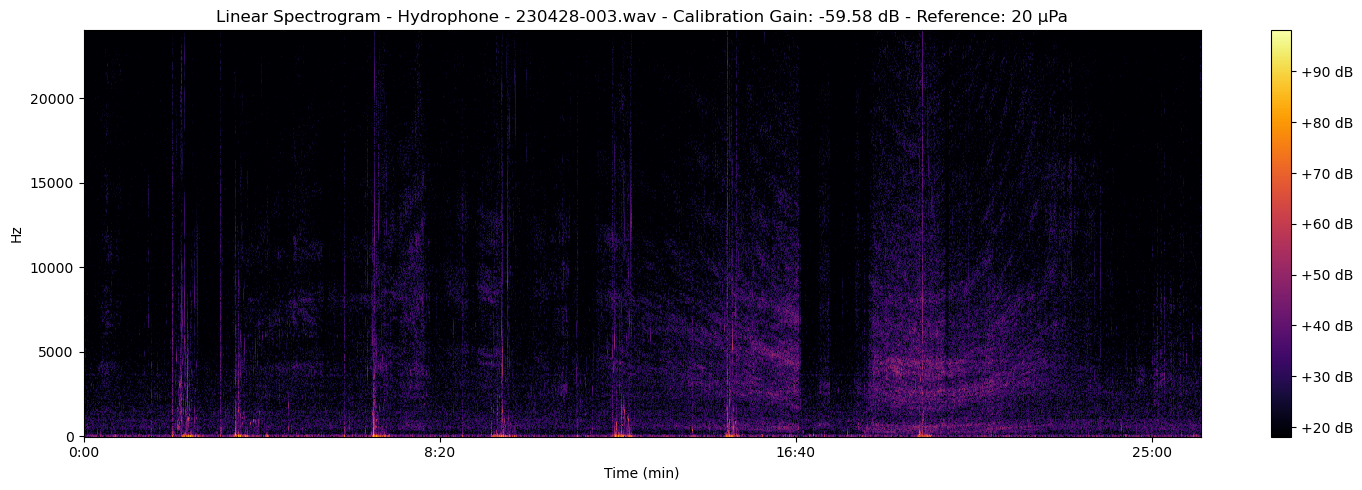

In [8]:
plt.figure(figsize=(15, 5))

im = librosa.display.specshow(spectrogram_dB, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear', cmap='inferno')
plt.colorbar(im, format='%+2.0f dB')
plt.title(f'Linear Spectrogram - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
time_unit = 'min' if spectrogram_dB.shape[1] / sr * HOP_LENGTH > 60 else 's'
plt.xlabel(f'Time ({time_unit})')

plt.tight_layout()

plt.show()

In [9]:
FRAME_SIZE = int(sr * 0.125) # 125 ms (fast RMS)
HOP_LENGTH = FRAME_SIZE // 2

audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
time = librosa.times_like(audio_spl, sr=sr, hop_length=HOP_LENGTH)

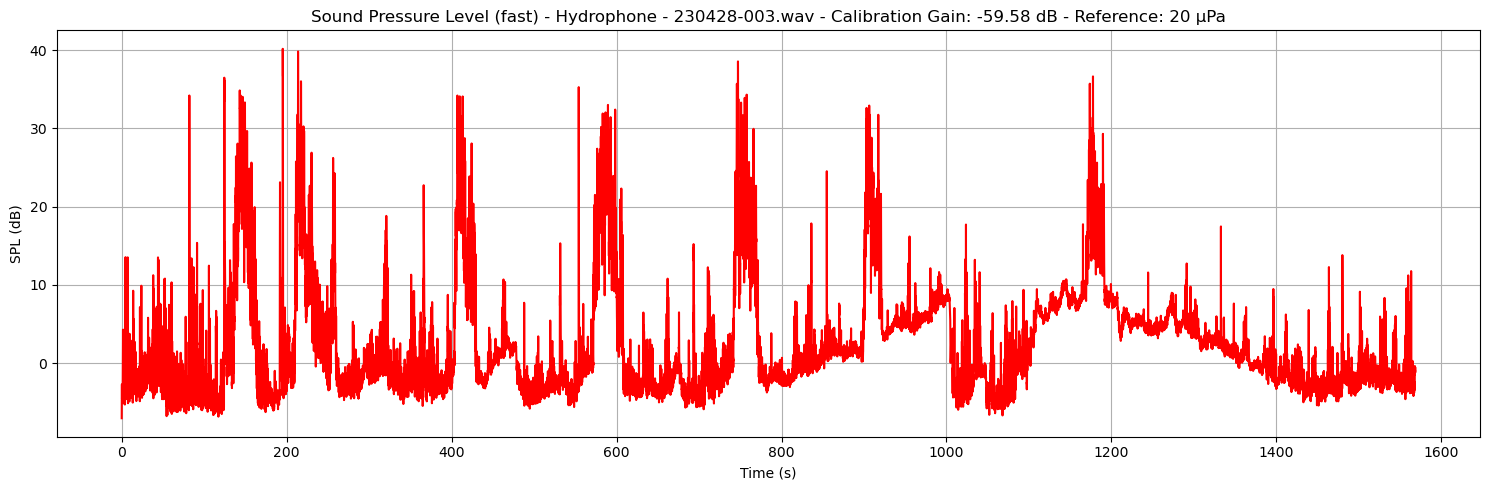

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(time, audio_spl, color='red')
plt.title(f'Sound Pressure Level (fast) - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
plt.xlabel('Time (s)')
plt.ylabel('SPL (dB)')
plt.grid()

plt.tight_layout()

plt.show()

In [11]:
AUDIO_CLIP_WAV_FOLDER = 'data/clips/wav/'
AUDIO_CLIP_TXT_FOLDER = 'data/clips/txt/'

In [12]:
data_paths = glob.glob(AUDIO_CLIP_WAV_FOLDER + '*.wav')
label_paths = glob.glob(AUDIO_CLIP_TXT_FOLDER + '*.txt')

data_paths = list(sorted(data_paths))
label_paths = list(sorted(label_paths))

datas = list()
labels = list()
multilabels = list()

for data_path, label_path in zip(data_paths, label_paths):
    audio, sr = librosa.load(data_path, sr=None, mono=False)
    
    with open(label_path, 'r') as f:
        multilabel = f.readlines()
        multilabel = [l.strip() for l in multilabel]

        if 'JUMP' in multilabel:
            label = 'JUMP'
        
        else:
            label = 'BACKGROUND'
            
    datas.append(audio)
    labels.append(label)
    multilabels.append(multilabel)

In [13]:
clips = list()

for idx, audio in enumerate(datas):
    audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
    
    filename = os.path.basename(data_paths[idx])
    label = labels[idx]
    multilabel = multilabels[idx]
    
    min_spl = np.min(audio_spl)
    max_spl = np.max(audio_spl)
    median_spl = np.median(audio_spl)
    mean_spl = np.mean(audio_spl)
    std_spl = np.std(audio_spl)
    
    clips.append([filename, label, multilabel, min_spl, max_spl, median_spl, mean_spl, std_spl])
    
clips_df = pd.DataFrame(clips, columns=['filename', 'label', 'multilabel', 'min_spl', 'max_spl', 'median_spl', 'mean_spl', 'std_spl'])
clips_df = clips_df.sort_values(by=['label', 'filename'])
clips_df = clips_df.reset_index(drop=True)

clips_df

,filename,label,multilabel,min_spl,max_spl,median_spl,mean_spl,std_spl
0,clip-230320-009-jump-2-0-0004.wav,BACKGROUND,[SWIM],6.023609,15.535339,10.465660,10.732316,2.666514
1,clip-230320-009-jump-2-1-0000.wav,BACKGROUND,[SWIM],5.454628,18.861237,7.804501,8.421465,3.089036
2,clip-230320-009-jump-2-1-0001.wav,BACKGROUND,[SWIM],3.836815,29.950829,12.010742,14.422818,7.202261
3,clip-230320-009-jump-2-1-0002.wav,BACKGROUND,[SWIM],5.585491,12.805431,10.690311,10.469370,1.585365
4,clip-230320-009-jump-2-1-0003.wav,BACKGROUND,[SWIM],4.630058,20.596962,11.882233,12.155878,3.487698
...,...,...,...,...,...,...,...,...
4595,clip-230428-003-0-0539.wav,JUMP,"[IDLE_MOTOR, JUMP]",-3.832615,-0.004078,-1.166679,-1.170130,0.785006
4596,clip-230428-003-0-0540.wav,JUMP,"[IDLE_MOTOR, JUMP]",-6.609802,-0.114452,-1.676758,-2.292592,1.600825
4597,clip-230428-003-0-0765.wav,JUMP,"[BOAT, JUMP]",-3.522907,-0.042675,-0.742447,-0.919278,0.716629
4598,clip-230428-003-0-0766.wav,JUMP,"[BOAT, JUMP]",-4.400223,1.231934,-0.036236,-0.338674,1.093193


Number of jump clips: 61


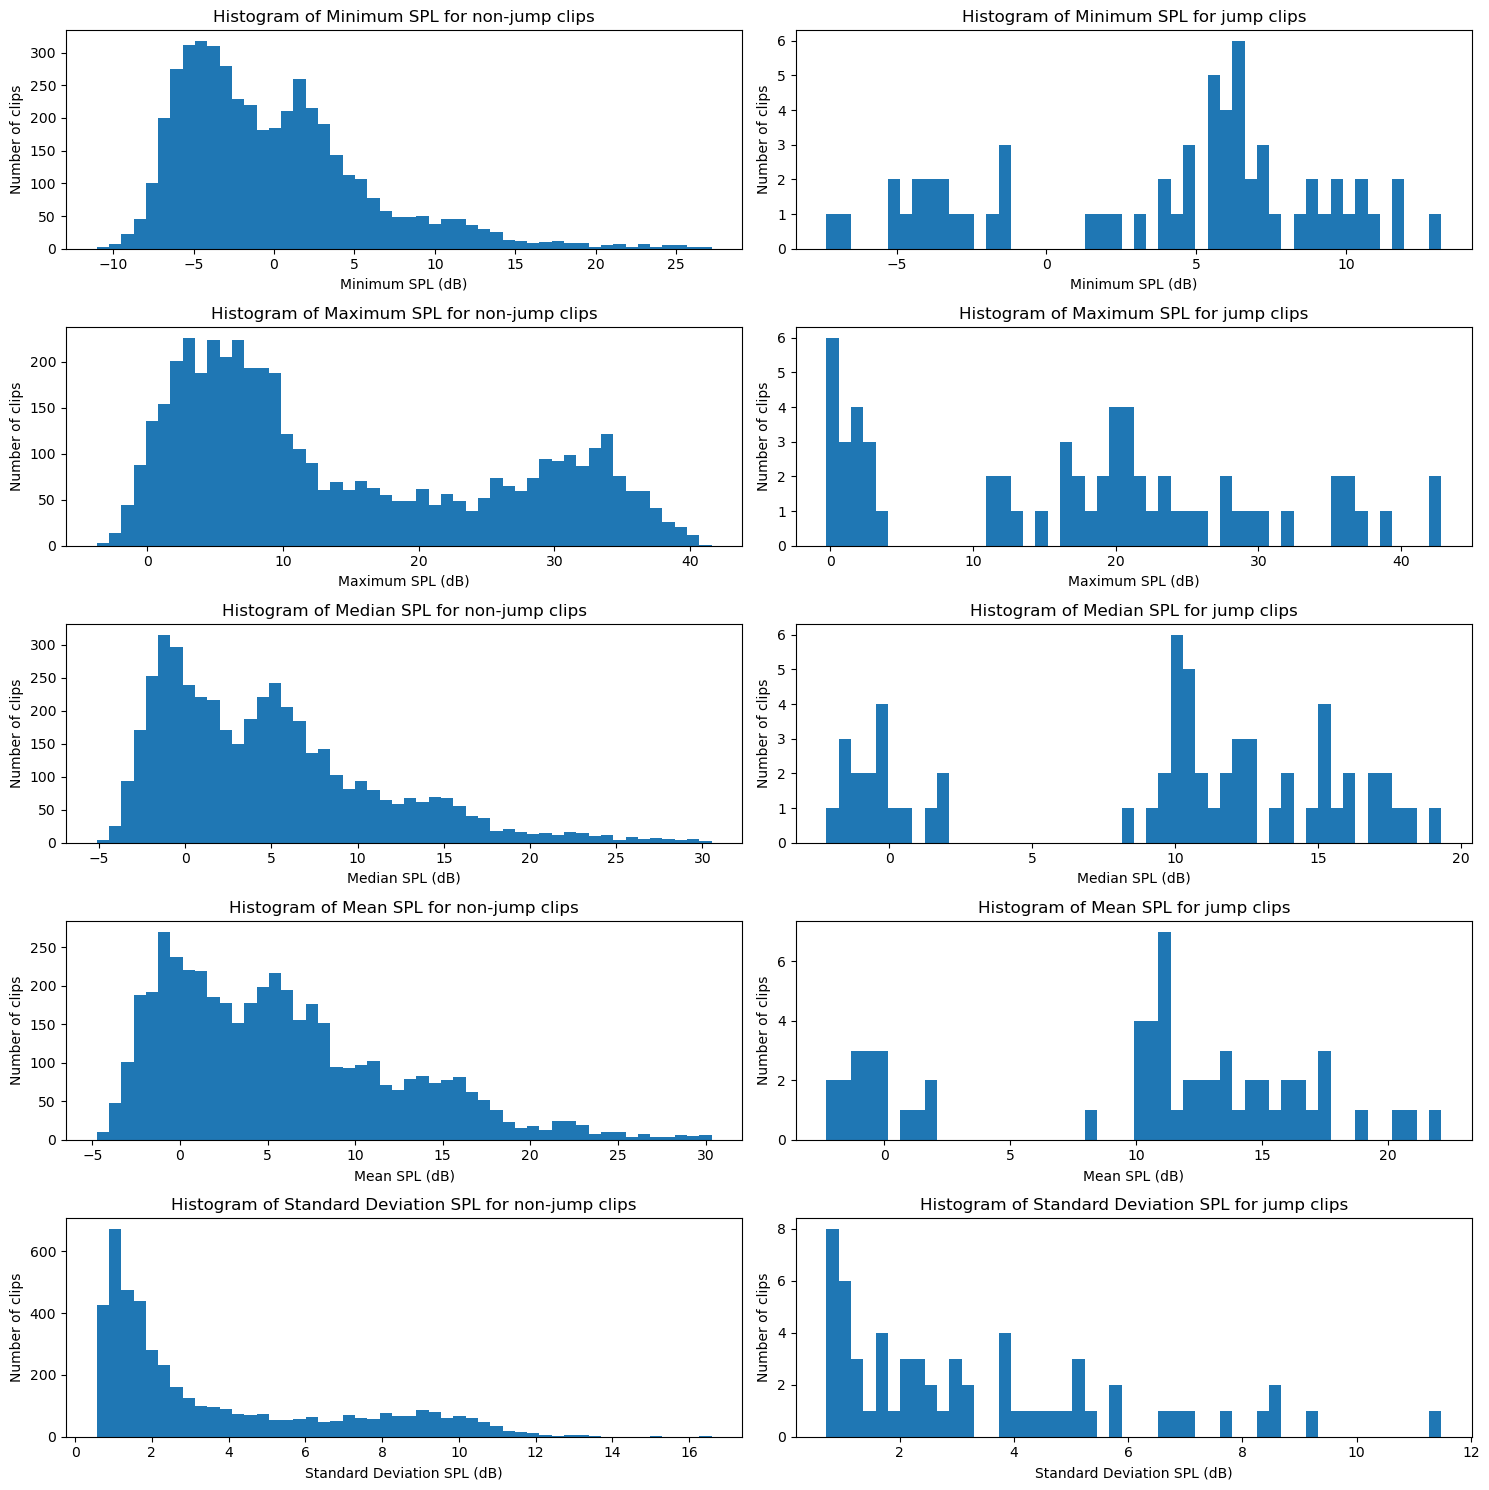

In [14]:
jump_clips_df = clips_df[clips_df['label'] == 'JUMP']
not_jump_clips_df = clips_df[clips_df['label'] != 'JUMP']

print(f'Number of jump clips: {jump_clips_df.shape[0]}')

features = ['min_spl', 'max_spl', 'median_spl', 'mean_spl', 'std_spl']
feature_labels = ['Minimum SPL', 'Maximum SPL', 'Median SPL', 'Mean SPL', 'Standard Deviation SPL']

fig, axs = plt.subplots(len(features), 2, figsize=(15, 3 * len(features)))

for feature_idx, (feature, feature_label) in enumerate(zip(features, feature_labels)):
    axs[feature_idx, 0].hist(not_jump_clips_df[feature], bins=50)
    axs[feature_idx, 0].set_title(f'Histogram of {feature_label} for non-jump clips')
    axs[feature_idx, 0].set_xlabel(f'{feature_label} (dB)')
    axs[feature_idx, 0].set_ylabel('Number of clips')

    axs[feature_idx, 1].hist(jump_clips_df[feature], bins=50)
    axs[feature_idx, 1].set_title(f'Histogram of {feature_label} for jump clips')
    axs[feature_idx, 1].set_xlabel(f'{feature_label} (dB)')
    axs[feature_idx, 1].set_ylabel('Number of clips')

plt.tight_layout()

plt.savefig('graphs/baseline-model-histograms.png')
plt.show()

In [15]:
not_jump_clips_df[not_jump_clips_df['max_spl'] >= 30]['multilabel'].value_counts()

[IDLE_MOTOR, BOAT]                      227
[IDLE_MOTOR]                            163
[IDLE_MOTOR, BRIDGE]                     94
[BOAT]                                   56
[IDLE_MOTOR, VOICE]                      43
[IDLE_MOTOR, UFO]                        37
[IDLE_MOTOR, BOAT, UFO]                  33
[PEE]                                    21
[BOAT, PEE]                              20
[IDLE_MOTOR, BRIDGE, VOICE]              19
[IDLE_MOTOR, BRIDGE, UFO]                10
[BOAT, UFO]                               9
[IDLE_MOTOR, PEE]                         7
[IDLE_MOTOR, BOAT, PEE]                   6
[IDLE_MOTOR, BOAT, VOICE]                 5
[SWIM]                                    4
[IDLE_MOTOR, VOICE, UFO]                  3
[IDLE_MOTOR, VOICE, VOICE]                3
[IDLE_MOTOR, BRIDGE, SCOOTER]             2
[IDLE_MOTOR, UFO, UFO]                    2
[IDLE_MOTOR, BOAT, BOAT]                  2
[BOAT, OBJECT_SPLASH]                     2
[BOAT, IDLE_MOTOR]              

In [16]:
LOWER_THRESHOLD = 20

predicted_labels = list()

for audio in datas:
    audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
    
    max_spl = np.max(audio_spl)
    
    if LOWER_THRESHOLD <= max_spl:
        predicted_labels.append('JUMP')
    else:
        predicted_labels.append('BACKGROUND')
        
predicted_labels = np.array(predicted_labels)

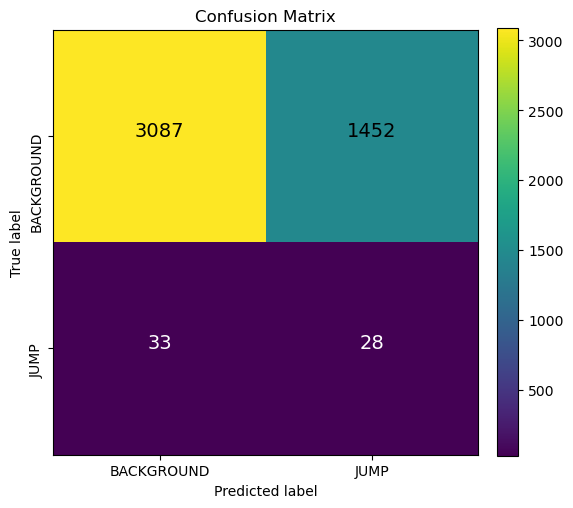

Accuracy: 0.68
Precision: 0.02
Recall: 0.46
F1: 0.04


In [17]:
cm = confusion_matrix(labels, predicted_labels, labels=['BACKGROUND', 'JUMP'])
plot_confusion_matrix(cm, classes=['BACKGROUND', 'JUMP'], title='Confusion Matrix', cmap=plt.cm.viridis)

print(f'Accuracy: {accuracy_score(labels, predicted_labels):.2f}')
print(f'Precision: {precision_score(labels, predicted_labels, pos_label="JUMP"):.2f}')
print(f'Recall: {recall_score(labels, predicted_labels, pos_label="JUMP"):.2f}')
print(f'F1: {f1_score(labels, predicted_labels, pos_label="JUMP"):.2f}')

In [18]:
THRESHOLDS = [10, 15, 20, 25, 30, 35, 40]

metrics = list()

for threshold in THRESHOLDS:
    print(f'Threshold: {threshold} dB')
    predicted_labels = list()

    for audio in datas:
        audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
        audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
        
        max_spl = np.max(audio_spl)
        
        if threshold <= max_spl:
            predicted_labels.append('JUMP')
        else:
            predicted_labels.append('BACKGROUND')
            
    predicted_labels = np.array(predicted_labels)
    
    acc = accuracy_score(labels, predicted_labels)
    prec = precision_score(labels, predicted_labels, pos_label='JUMP')
    rec = recall_score(labels, predicted_labels, pos_label='JUMP')
    f1 = f1_score(labels, predicted_labels, pos_label='JUMP')
    cm = confusion_matrix(labels, predicted_labels, labels=['BACKGROUND', 'JUMP'])
    
    metrics.append((threshold, acc, prec, rec, f1, cm))

Threshold: 10 dB
Threshold: 15 dB
Threshold: 20 dB
Threshold: 25 dB
Threshold: 30 dB
Threshold: 35 dB
Threshold: 40 dB


Threshold: 15 dB
Precision: 0.02
Recall: 0.64
Accuracy: 0.61
F1: 0.04

Threshold: 25 dB
Precision: 0.01
Recall: 0.26
Accuracy: 0.73
F1: 0.03

Threshold: 35 dB
Precision: 0.03
Recall: 0.13
Accuracy: 0.94
F1: 0.05



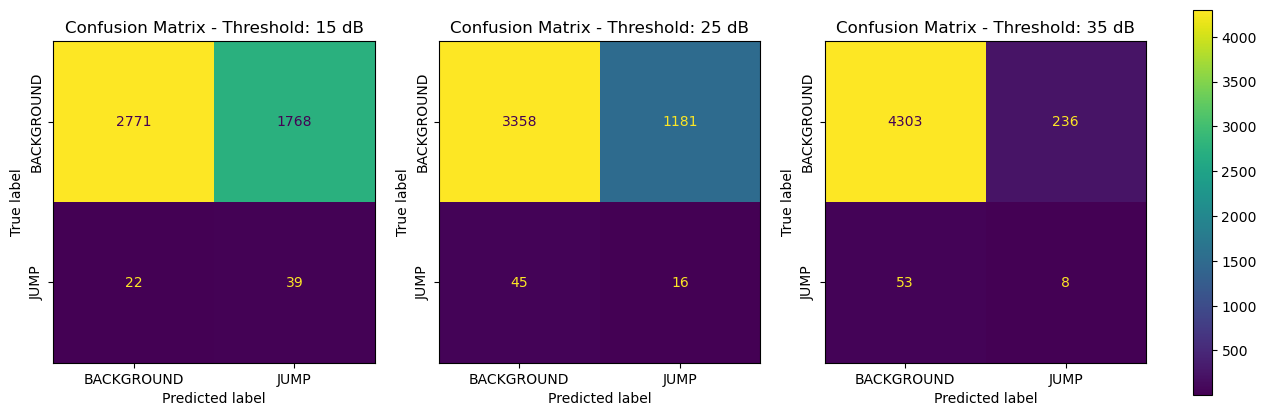

In [19]:
SELECTED = [15, 25, 35]
CLASSES = ['BACKGROUND', 'JUMP']

selected_metrics = [m for m in metrics if m[0] in SELECTED]

fig, axs = plt.subplots(1, len(selected_metrics), figsize=(5 * len(selected_metrics), 5))
axs = axs.ravel()

for idx, (threshold, acc, prec, rec, f1, cm) in enumerate(selected_metrics):
    print(f'Threshold: {threshold} dB')
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f'Accuracy: {acc:.2f}')
    print(f'F1: {f1:.2f}')
    print()
    
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
    disp.plot(ax=axs[idx], values_format='.4g')
    
    disp.ax_.set_yticklabels(CLASSES, rotation=90, va='center')
    disp.ax_.set_title(f'Confusion Matrix - Threshold: {threshold} dB')
    
    disp.im_.colorbar.remove()

fig.colorbar(disp.im_, ax=axs, fraction=0.02, pad=0.04)

plt.savefig('graphs/baseline-model-confusion-matrices.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
LOWER_FREQ = 1
UPPER_FREQ = 5000 #sr / 2 - 1
FILTER_TYPE = 'bandpass'
ORDER = 4

b, a = signal.butter(ORDER, [LOWER_FREQ, UPPER_FREQ], btype=FILTER_TYPE, fs=sr)

clips_filtered = list()

for idx, audio in enumerate(datas):
    filtered_audio = signal.filtfilt(b, a, audio)
    
    audio_rms = librosa.feature.rms(y=filtered_audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
    
    filename = os.path.basename(data_paths[idx])
    label = labels[idx]
    
    min_spl = np.min(audio_spl)
    max_spl = np.max(audio_spl)
    median_spl = np.median(audio_spl)
    mean_spl = np.mean(audio_spl)
    std_spl = np.std(audio_spl)
    
    clips_filtered.append([filename, label, min_spl, max_spl, median_spl, mean_spl, std_spl])
    
clips_filtered_df = pd.DataFrame(clips_filtered, columns=['filename', 'label', 'min_spl', 'max_spl', 'median_spl', 'mean_spl', 'std_spl'])
clips_filtered_df = clips_filtered_df.sort_values(by=['label', 'filename'])
clips_filtered_df = clips_filtered_df.reset_index(drop=True)

clips_filtered_df

,filename,label,min_spl,max_spl,median_spl,mean_spl,std_spl
0,clip-230320-009-jump-2-0-0004.wav,BACKGROUND,79.769859,159.769867,116.408539,119.217308,26.760288
1,clip-230320-009-jump-2-1-0000.wav,BACKGROUND,81.024467,161.024475,119.740944,120.459854,26.286713
2,clip-230320-009-jump-2-1-0001.wav,BACKGROUND,85.957664,165.957672,124.149513,125.336472,26.433287
3,clip-230320-009-jump-2-1-0002.wav,BACKGROUND,84.297325,164.297333,122.100487,124.104912,26.668213
4,clip-230320-009-jump-2-1-0003.wav,BACKGROUND,69.454971,149.454971,107.111160,109.683823,26.598717
...,...,...,...,...,...,...,...
4595,clip-230428-003-0-0539.wav,JUMP,86.072197,166.072205,124.287148,125.649086,26.376245
4596,clip-230428-003-0-0540.wav,JUMP,74.460793,154.460785,112.018578,113.959938,26.660418
4597,clip-230428-003-0-0765.wav,JUMP,75.991714,155.991714,113.986305,115.654442,26.565485
4598,clip-230428-003-0-0766.wav,JUMP,56.375610,136.375610,92.505287,90.556702,26.261354


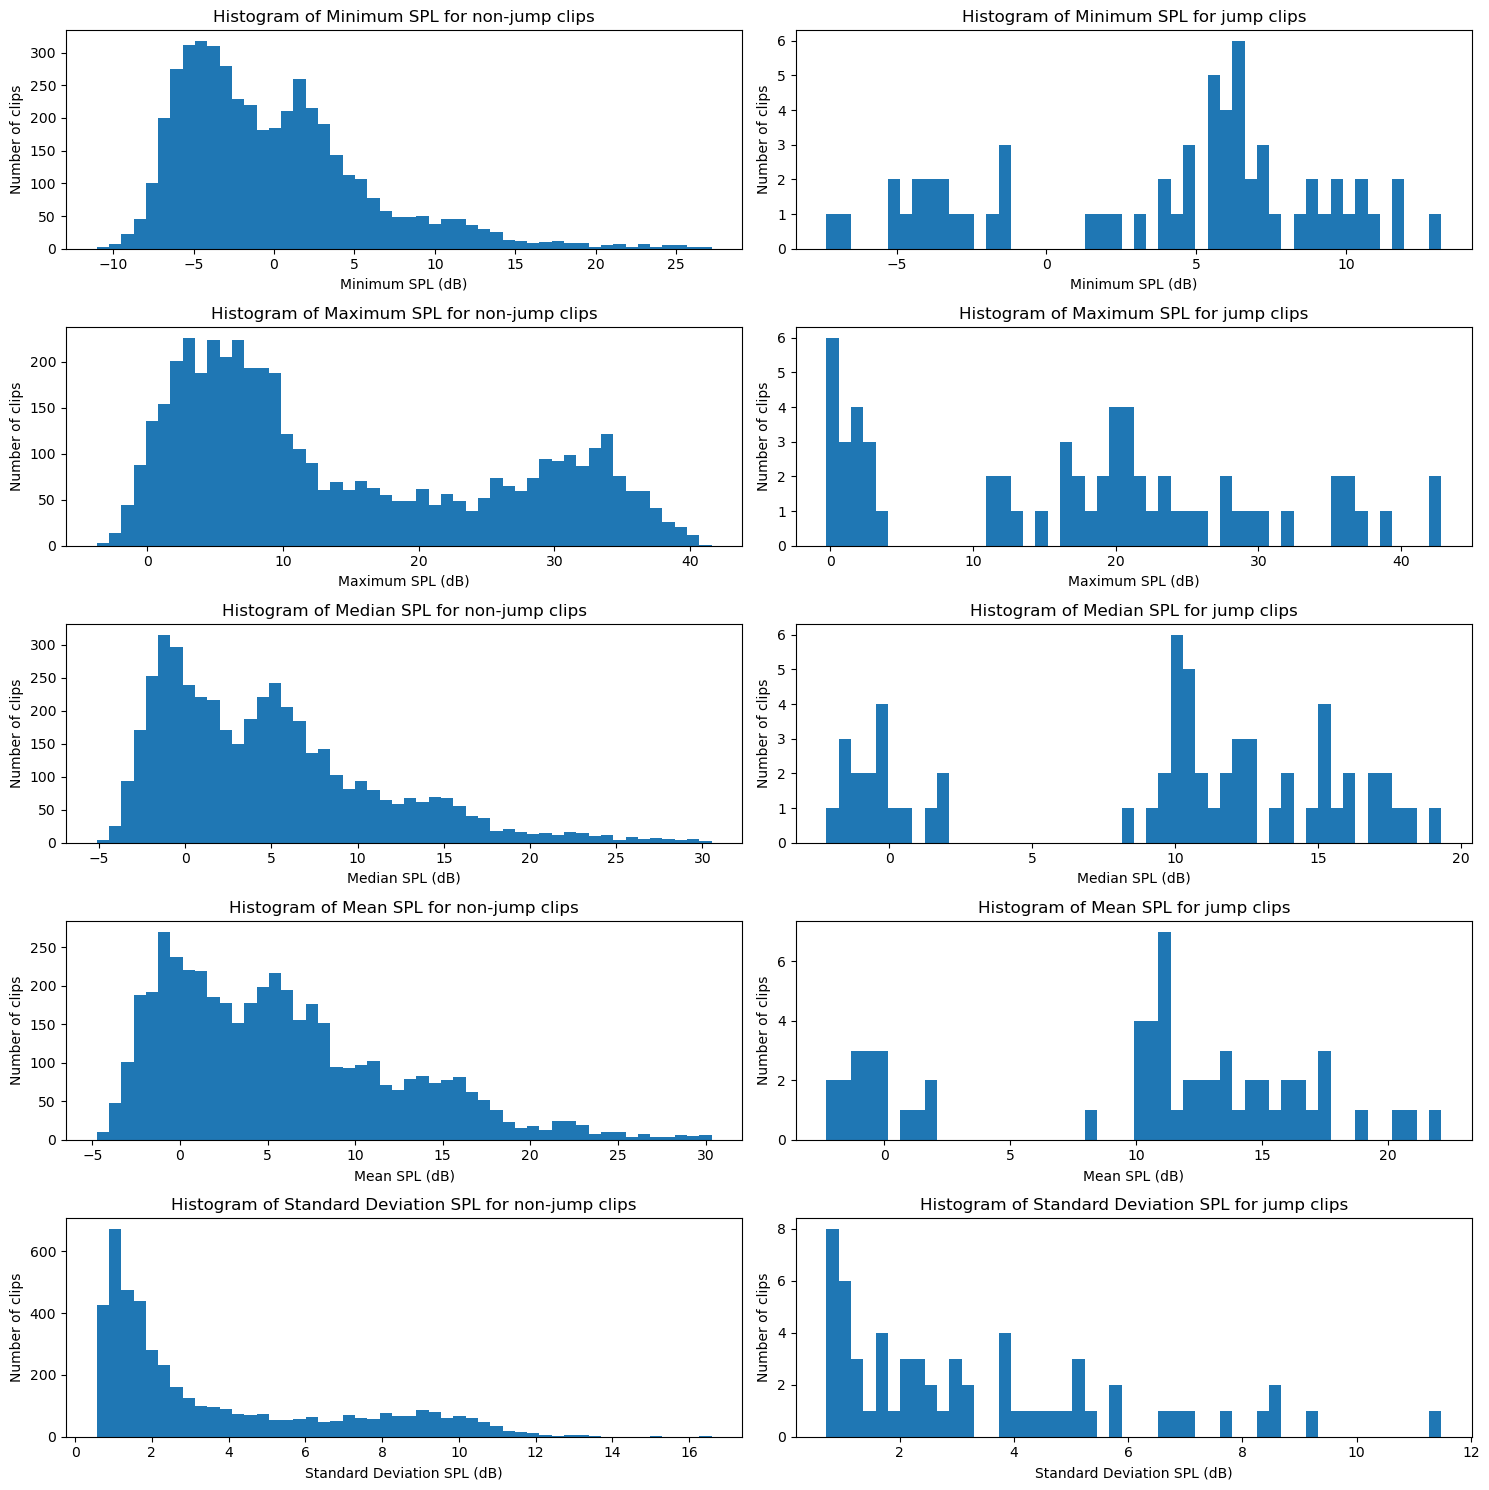

In [21]:
jump_clips_df = clips_df[clips_filtered_df['label'] == 'JUMP']
not_jump_clips_df = clips_df[clips_filtered_df['label'] != 'JUMP']

features = ['min_spl', 'max_spl', 'median_spl', 'mean_spl', 'std_spl']
feature_labels = ['Minimum SPL', 'Maximum SPL', 'Median SPL', 'Mean SPL', 'Standard Deviation SPL']

fig, axs = plt.subplots(len(features), 2, figsize=(15, 3 * len(features)))

for feature_idx, (feature, feature_label) in enumerate(zip(features, feature_labels)):
    axs[feature_idx, 0].hist(not_jump_clips_df[feature], bins=50)
    axs[feature_idx, 0].set_title(f'Histogram of {feature_label} for non-jump clips')
    axs[feature_idx, 0].set_xlabel(f'{feature_label} (dB)')
    axs[feature_idx, 0].set_ylabel('Number of clips')

    axs[feature_idx, 1].hist(jump_clips_df[feature], bins=50)
    axs[feature_idx, 1].set_title(f'Histogram of {feature_label} for jump clips')
    axs[feature_idx, 1].set_xlabel(f'{feature_label} (dB)')
    axs[feature_idx, 1].set_ylabel('Number of clips')

plt.tight_layout()

plt.savefig('graphs/baseline-model-histograms.png')